In [1]:
# !pip install perceval-quandela
# !pip install tqdm

In [2]:
import perceval as pcvl
import numpy as np
from math import comb
from scipy.optimize import minimize
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
import tqdm as tqdm
from perceval.simulators import Simulator
from perceval.backends import SLOSBackend


In [3]:
print(pcvl.__version__)

0.9.1


In [4]:
nphotons = 4

random_seed = np.random.randint(0, 10000)
np.random.seed(random_seed)
print("Random Seed:", random_seed)

Random Seed: 5848


In [5]:
# Boundary condition 
coefii = 10

# del_0 = 0  #del
# omega_0 = 0     #w
# del_0_v = -1/coefii
# omega_0_v = 383.9911/coefii
del_0_v = 0.236
omega_0_v = 37.72

In [6]:
# Differential equation parameters
ws = 376.9911

# ws = 0.376
# coefii = ws/4
K1 = 5/coefii
K2 = 10/coefii
K3 = 1.7/coefii
ws = ws/coefii

# def F(u_zegond,u_prime, u, x):       # DE, works with numpy arrays
#     return u_zegond+np.sin(x)
def F(u_zegond,u_prime, u, x):       # DE, works with numpy arrays
    # print(len(u_zegond))
    # print(len(u_prime))
    # print(len(u))
    delta = u
    delta_prime = u_prime
    omega = delta_prime+ws
    omega_prime = u_zegond
    return (delta_prime+ws-omega)+omega_prime-K1+K2*np.sin(coefii*delta)+K3*(-ws+omega)*coefii

In [7]:
# # Boundary condition (f(x_0)=f_0)
# x_0 = 0
# f_0 = np.sin(0)

In [8]:
# Differential equation's exact solution - for comparison
def u(x):
    return np.sin(x)

In [9]:
# Modeling parameters
n_grid = 50    # number of grid points of the discretized differential equation
range_min = 0  # minimum of the interval on which we wish to approximate our function
range_max = 1  # maximum of the interval on which we wish to approximate our function
X = np.linspace(range_min, range_max-range_min, n_grid)  # Optimisation grid

In [10]:
# Parameters of the quantum machine learning procedure
N = nphotons              # Number of photons
m = nphotons              # Number of modes
eta = 5                   # weight granted to the initial condition
a = 200                   # Approximate boundaries of the interval that the image of the trial function can cover
fock_dim = comb(N + m - 1, N)
# lambda coefficients for all the possible outputs
lambda_random = 2 * a * np.random.rand(fock_dim) - a
# dx serves for the numerical differentiation of f
dx = (range_max-range_min) / (n_grid - 1)

In [11]:
# Input state with N photons and m modes
input_state = pcvl.BasicState([1]*N+[0]*(m-N))
print(input_state)

|1,1,1,1>


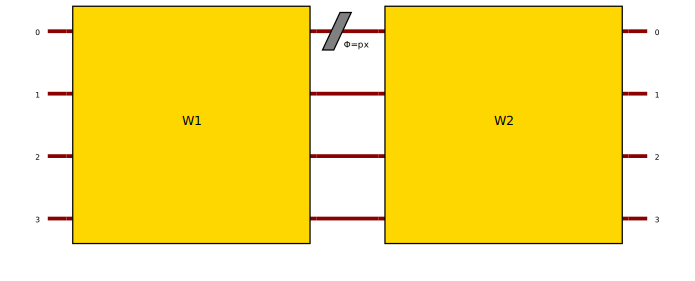

In [12]:

"Haar unitary parameters"
# number of parameters used for the two universal interferometers (2*m**2 per interferometer)
parameters = np.random.normal(size=4*m**2)

px = pcvl.P("px")
c = pcvl.Unitary(pcvl.Matrix.random_unitary(m, parameters[:2 * m ** 2]), name="W1")\
     // (0, pcvl.PS(px))\
     // pcvl.Unitary(pcvl.Matrix.random_unitary(m, parameters[2 * m ** 2:]), name="W2")


backend = pcvl.BackendFactory().get_backend("SLOS")
backend.set_circuit(pcvl.Unitary(pcvl.Matrix.random_unitary(m)))
backend.preprocess([input_state])

pcvl.pdisplay(c)

In [13]:
def computation(params):
    global current_loss
    global computation_count
    "compute the loss function of a given differential equation in order for it to be optimized"
    computation_count += 1

    loss_i = 0 

    delta_0 = None  # boundary condition
    omega_0 = None  # boundary condition

    coefs = lambda_random  # coefficients of the M observable
    # initial condition with the two universal interferometers and the phase shift in the middle
    U_1 = pcvl.Matrix.random_unitary(m, params[:2 * m ** 2])
    U_2 = pcvl.Matrix.random_unitary(m, params[2 * m ** 2:])

    px = pcvl.P("x")
    c = pcvl.Unitary(U_2) // (0, pcvl.PS(px)) // pcvl.Unitary(U_1)

    px.set_value(np.pi * range_min)
    # U = c.compute_unitary(use_symbolic=False)
    # backend.U = U
    backend.set_circuit(c)
    delta_0 = np.sum(np.multiply(backend.all_prob(input_state), coefs))
    



    # loss=0


    # Y[0] is before the domain we are interested in (used for differentiation), x_0 is at Y[1]
    Y = np.zeros(n_grid + 2)

    # x_0 is at the beginning of the domain, already calculated
    Y[1] = delta_0

    px.set_value(np.pi * (range_min - dx)/range_max)
    # backend.U = c.compute_unitary(use_symbolic=False)
    backend.set_circuit(c)
    Y[0] = np.sum(np.multiply(backend.all_prob(input_state), coefs))


    for i in range(1, n_grid):
        x = X[i]
        px.set_value(np.pi * x/range_max)
        # backend.U = c.compute_unitary(use_symbolic=False)
        backend.set_circuit(c)
        Y[i + 1] = np.sum(np.multiply(backend.all_prob(input_state), coefs))

    px.set_value(np.pi * (range_max + dx)/range_max)
    # backend.U = c.compute_unitary(use_symbolic=False)
    backend.set_circuit(c)
    Y[n_grid + 1] = np.sum(np.multiply(backend.all_prob(input_state), coefs))


    # Differentiation
    Y_prime = (Y[2:] - Y[:-2])/(2*dx)
    omega_0 = Y_prime[0]+ws

    Y_zegond = (Y_prime[2:] - Y_prime[:-2])/(2*dx)

    loss_i += np.sum((F(Y_zegond,Y_prime[1:-1], Y[2:-2], X[1:-1]))**2)

    # boundary condition given a weight eta
    loss_b = eta * (delta_0 - del_0_v) ** 2 * len(X)
    loss_b += eta * (omega_0 - omega_0_v) ** 2 * len(X)



    current_loss = (loss_i+loss_b) / len(X)
    return current_loss

In [14]:
a = [1,2,3,4,5,6,7,8]
print(a[2:])
print(a[:-2])
print(a[2:-2])


[3, 4, 5, 6, 7, 8]
[1, 2, 3, 4, 5, 6]
[3, 4, 5, 6]


In [15]:
def callbackF(parameters):
    """callback function called by scipy.optimize.minimize allowing to monitor progress"""
    global current_loss
    global computation_count
    global loss_evolution
    global start_time
    global best_param

    now = time.time()
    pbar.set_description("M= %d Loss: %0.5f #computations: %d elapsed: %0.5f" %
                         (m, current_loss, computation_count, now-start_time))
    pbar.update(1)
    loss_evolution.append((current_loss, now-start_time))
    computation_count = 0
    start_time = now
    best_param = parameters

In [16]:
computation_count = 0
current_loss = 0
start_time = time.time()
loss_evolution = []

pbar = tqdm.tqdm()
res = minimize(computation, parameters, callback=callbackF, method='BFGS', options={'gtol': 1E-2})

0it [00:00, ?it/s]

M= 4 Loss: 0.00082 #computations: 130 elapsed: 1.01747: : 164it [01:54,  1.22s/it]   

In [17]:
# print("Unitary parameters", res.x)
print("Unitary parameters", best_param)
np.save('seed='+str(random_seed)+' n_photon='+str(nphotons)+'.npy', best_param)


Unitary parameters [-1.45794953e-01  2.36978572e-01 -5.24159279e-01 -4.32236073e+00
 -3.26411718e+00  5.83146687e+00 -2.07820463e+00  1.22550166e+00
 -1.31119681e-01 -3.33258244e+00  4.58240599e-01 -3.43558427e+00
  2.52670157e-01  1.46798992e+00 -3.35872244e-01  6.34731956e-01
  1.99099528e-01  3.72653052e+00  1.51067597e+00 -1.19754830e+00
  5.81071068e+00 -6.02893193e-01  3.38274654e+00  1.85834362e+00
 -2.74345915e-02  1.42525779e+00 -7.72901194e-01 -7.35021339e-01
  3.28994496e-01  1.73794260e+00 -4.73863667e-03  1.90307355e+00
  2.43972865e+00  1.45831556e+00 -1.57765457e+00  1.06304313e+00
  2.09328884e+00  8.37159296e-01  2.16198707e+00 -1.60157252e+00
 -8.64834655e-01  2.32095299e+00  5.51758782e+00 -4.46302236e-01
 -8.02307167e-01 -1.80536413e+00  2.41902908e-02  9.25899036e-01
 -4.47284659e-01 -3.75501610e+00 -1.61889941e+00 -8.29056196e-01
 -1.99370392e+00  1.09651302e+00  5.78720024e-01  4.55429146e-01
 -5.26666600e-02  5.74983650e+00  4.43750036e+00  1.14684466e-01
 -4.56

In [18]:
def plot_solution(m, N, X, optim_params, lambda_random,label):
    Y = []
    U_1 = pcvl.Matrix.random_unitary(m, optim_params[:2 * m ** 2])
    U_2 = pcvl.Matrix.random_unitary(m, optim_params[2 * m ** 2:])
    px = pcvl.P("x")
    c = pcvl.Unitary(U_2) // (0, pcvl.PS(px)) // pcvl.Unitary(U_1)

    for x in X:
        px.set_value(np.pi * x/range_max)
        # U = c.compute_unitary(use_symbolic=False)
        # backend.U = U
        backend.set_circuit(c)
        f_theta = np.sum(np.multiply(backend.all_prob(input_state), lambda_random))
        Y.append(f_theta)

    
    plt.plot(X, Y, label=label+" Approximation with {} photons".format(N))
    return Y

In [19]:
# y_delta_real = [-0.1, -0.08568864375010266, -0.07135199292327042, -0.05703216366155178, -0.04277533332758968, -0.028630566403092566, -0.014648393492369936, -0.0008786099410683636, 0.012629993562057113, 0.025830965225360485, 0.03868190003112095, 0.05114514907683676, 0.06318818053413534, 0.07478349631699908, 0.08590929364185632, 0.09655108128205876, 0.10669910851327256, 0.11634802541217151, 0.12549688285643618, 0.13414913252475494, 0.1423124546002818, 0.14999727816970396, 0.1572170147933966, 0.16398646160587024, 0.17032150117763253, 0.17623910151518826, 0.18175731606103976, 0.18689528211221512, 0.19167252338163385, 0.1961073022258, 0.2002172705183872, 0.2040196495808423, 0.20753123018238517, 0.21076837254000894, 0.21374700631847987, 0.2164826306303374, 0.21899031403589397, 0.22128469454323552, 0.2233792634241711, 0.22528520015009165, 0.22701309424038968, 0.22857304585789437, 0.22997466468065175, 0.2312270699019247, 0.23233889023019288, 0.23331826388915283, 0.23417283861771784, 0.2349097716700181, 0.2355355471757422, 0.23605508170803655]
# y_omega_real = [38.39911, 38.40131255162024, 38.401559501400065, 38.399627615014815, 38.39535272010845, 38.38863569037213, 38.37944575798523, 38.36781828175373, 38.35385457506316, 38.33771250498817, 38.31960064799821, 38.29975795463622, 38.27844654658136, 38.25594953663366, 38.232548774138536, 38.20852344187769, 38.184133101993716, 38.15961422638989, 38.135180196730154, 38.11102130443908, 38.0873045267779, 38.0641648590319, 38.04170495996719, 38.020008128295665, 37.999139183467754, 37.979144465672405, 37.96005183583712, 37.94187079269068, 37.92460193204962, 37.90823330461032, 37.892744190413474, 37.87811073974539, 37.864305973137945, 37.851299781368624, 37.83905892546051, 37.82754703668229, 37.816724616548235, 37.80654903681822, 37.7969789305147, 37.78797953688034, 37.779515522995986, 37.77155243468513, 37.76405670589686, 37.75699565870589, 37.75033750331248, 37.744051338042496, 37.73810714934741, 37.73247581180426, 37.72712975291509, 37.7220465421391]
y_delta_real = [0.23605626591042683, 0.2364759058355538, 0.23679882182535492, 0.23702894040058167, 0.2371699303438648, 0.2372252026997144, 0.23719791077451977, 0.23709095013654943, 0.23690695861595135, 0.23664831630475258, 0.2363171455568596, 0.23591528613307364, 0.23544388226423293, 0.23490355799761406, 0.23429481285927523, 0.23361802878044674, 0.23287347009753093, 0.23206128355210237, 0.23118149829090756, 0.23023402586586536, 0.22921866023406648, 0.22813507775777397, 0.22698283720442267, 0.22576137974661986, 0.22447002896214488, 0.22310810181022783
, 0.22167476327624866, 0.22016846815788546, 0.21858767515685332, 0.2169308927288243, 0.21519667908342752, 0.2133836421842492, 0.21149043974883255, 0.20951577924867767, 0.20745841790924208, 0.20531716270993974, 0.20309087038414234, 0.20077844741917794, 0.19837885005633207, 0.19589108429084748, 0.1933142058719233, 0.1906473205806473, 0.18788964538548072, 0.18504060801535507, 0.18209990215942204, 0.1790675122127715, 0.17594371327643182, 0.1727290711573695, 0.1694244423684894, 0.16603097412863455]
y_omega_real = [37.722042745006526, 37.71719508647432, 37.71256572490202, 37.70813485706719, 37.70388338850834, 37.699792933524925, 37.69584581517736, 37.692025065287005, 37.68831442443621, 37.68469834196822, 37.6811619759873, 37.67769135276257, 37.674275039859445, 37.67090263963681, 37.667564062585406, 37.66424963715157, 37.6609501097372, 37.657656644699784, 37.65436082435239, 37.651054648963665, 37.647730536757834, 37.644381323914715, 37.64100026456968, 37.63758103081373, 37.63411771269338, 37.63060536744424, 37.62704088228197, 37.62342015361117, 37.619739669789496, 37.61599666383029, 37.6121891134026, 37.6083157408312, 37.60437601309654, 37.600370141834794, 37.59629908333784, 37.59216453855324, 37.58796895308429, 37.58371551718997, 37.57940816578498, 37.575051578439705, 37.570651179380256, 37.56621315055906, 37.56174647089014, 37.557261719975195, 37.55276979111383, 37.54828289254363, 37.5438145474401, 37.53937959391669, 37.5349941850248, 37.53067578875376]


Text(0, 0.5, 'del_t')

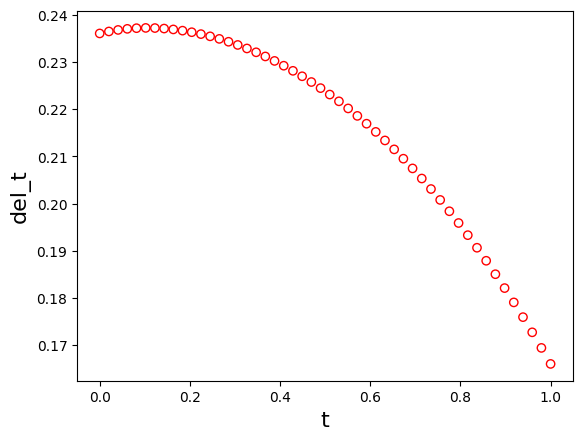

In [20]:
plt.figure()

plt.scatter(X,y_delta_real,facecolors='none', edgecolors='r', label='True - del_t')
# plt.scatter(X,pred_train_X, color='red',marker="x",s=4,label='Prediction - del_t')
plt.xlabel('t',fontsize=16)
plt.ylabel('del_t',fontsize=16)

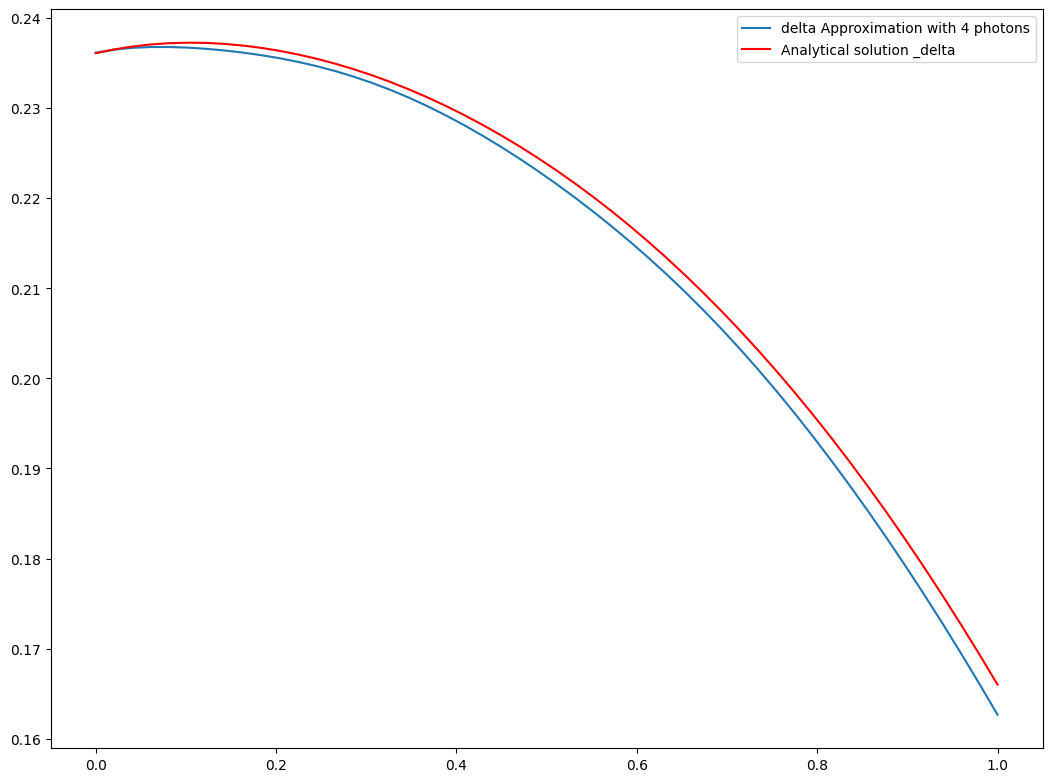

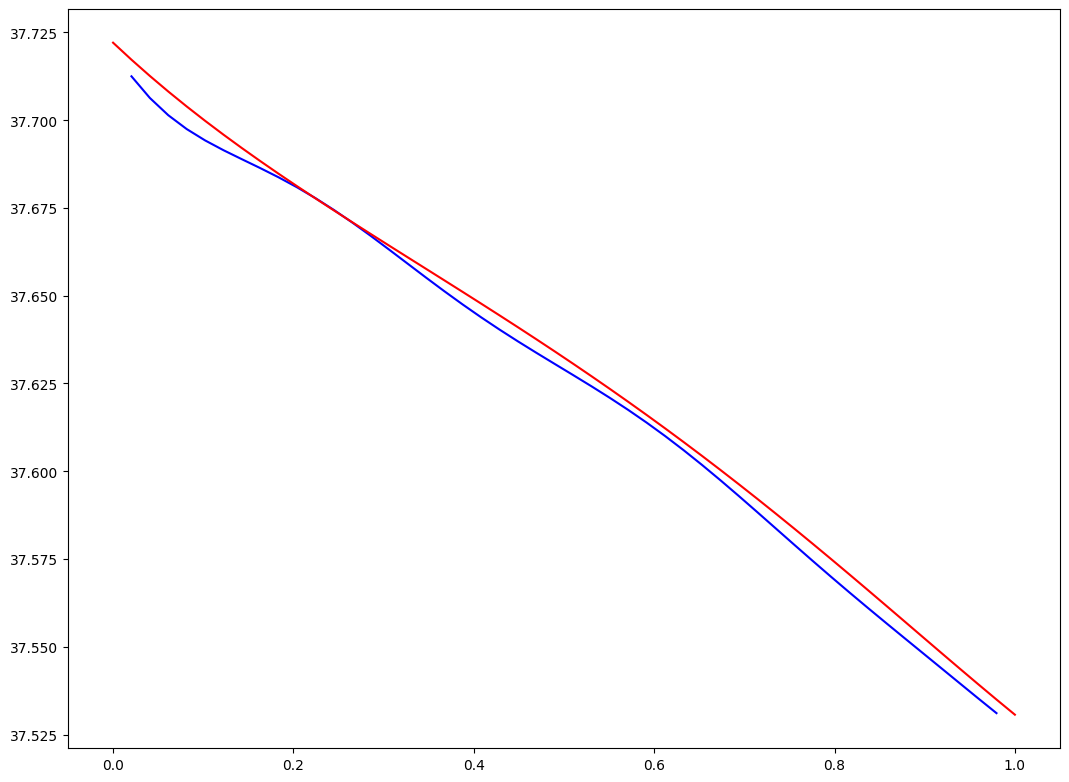

In [21]:
# X = np.linspace(range_min, range_max, 50)

# Change the plot size
default_figsize = mpl.rcParamsDefault['figure.figsize']
mpl.rcParams['figure.figsize'] = [2 * value for value in default_figsize]

# delta_pred = plot_solution(m, N, X, res.x, lambda_random,'delta')
delta_pred = plot_solution(m, N, X, best_param, lambda_random,'delta')

plt.plot(X, y_delta_real, 'r', label='Analytical solution _delta')
plt.legend()

plt.figure()

delta_pred = np.array(delta_pred)
delta_prime = (delta_pred[2:] - delta_pred[:-2])/(2*dx)
omega = delta_prime+ws
plt.plot(X[1:-1], omega, 'b', label='prediction solution _omega')
plt.plot(X, y_omega_real, 'r', label='Analytical solution _omega')
# plt.legend()


plt.show()

Text(0, 0.5, 'Loss function value')

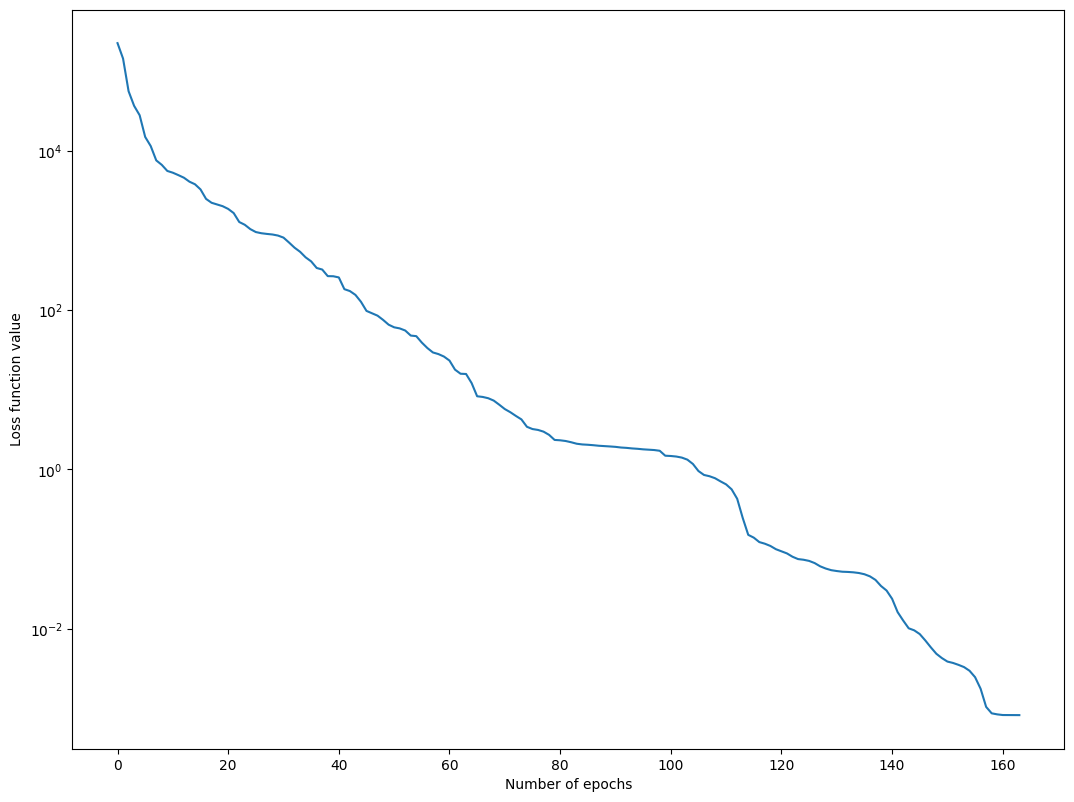

In [22]:

plt.plot([v[0] for v in loss_evolution])
plt.yscale("log")
plt.xlabel("Number of epochs")
plt.ylabel("Loss function value")